
## A) Feature Engineering:
  ###  Data Loading
  ###  Data Preparation
  > + Divide into feature_subsets.<br>
  > + Re-sample for tuning.<br>
  
  ###  Cross-validation (SGDClassifier/KNN/LogReg/RandomForest)<br>
  
  #### Run Cross-validation: <br>    
  > + Using All feature_subsets, no scaling.<br>
  > + Using All feature_subsets, scaled.<br>
  
  #### Multi-class or Binary?: <br>    
  > + Logistic Regression: multi-class.<br>
  > + Logistic Regression: binary.<br>
  
  ###  Summary and conclusions
  
## B) Machine Learning Models:

### + LogisticRegression
> + Run full model: binary classification.<br>
> + Calculate confusion matrix & classification report.<br>
> + Analyze results.<br>

### + RandomForestClassifier
> + Hyper parameter tuning<br>
> + Implement hyperparameters<br>
> + Most important features<br>
> + Calculate confusion matrix and classification report.<br>

###  Summary and conclusions

## C) Final Pipeline: 

###  Recommeded Future Work

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from math import sqrt

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Data Loading

In [14]:
df = pd.read_csv('dec19_400k_rs1_edt_fillna.csv') # load data file

In [15]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [21]:
def calc_confmatrix_and_classfrep(ytest, pred, title):
    
    """ this function calculates the confusion matrix and classfication report, 
    and plots them"""
    
    cm = confusion_matrix(y_test, pred)
    cr = classification_report(y_test, pred)
    print(cm)
    print(cr)
    
    # plot

    df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7));
    plt.title(title);
    sns.set(font_scale=1.4)#for label size
    cm_plot = sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})

    return cm_plot

## A) Feature Engineering:

#### Data Preparation for testing:

In the code below, the term test_batch1 etc. are used to signify feature subsets used in the cross-validation and modeling. However, in the documentation and written reports, these are refered to as feature_subsets in order to avoid confusion with naming conventions used elsewhere in machine learning.<br>
Below is a list of such batches and their equivalent:<br>
    **code**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**report**<br>
    test_batch1 &emsp; &emsp;feature_subset1<br>
    test_batch2 &emsp; &emsp;feature_subset2<br>
    test_batch3 &emsp; &emsp;feature_subset3<br>
    test_batch4 &emsp; &emsp;feature_subset4<br>
    test_batch5 &emsp; &emsp;feature_subset5<br>
    

##### Method:
Features are bundled into subsets.This starts with feature_subset1, and more features are incrementally added to form the next subset. Subset1 contains longitude, latitude, distance and weather numerical features only(10features). Five categorical features were added to subset1, and encoded with 0s and 1s through panda's get_dummies function. The resulting 22 features form subset2. Subset3 has the States feature added in, and converted to dummy variables (71 features). Subset4, has 89features, including all points of interest(such as Crossing, Railway, Bump etc.), and 'wasnull' which is an engineered feature indicating that the value was missing. In batch5, the 'wasnull' column was dropped, resulting in 82 features.<br> 
Details of how these features were engineered are in the code below.<br>

In the next step, these subsets will be tested with the different classification models to indicate which gives the maximum cross_validation_score.<br>

In [16]:
# list of 'Blocks' of features used in testing:

# Basic numeric features:
basic_features = ['Severity','Start_Lat', 'Start_Lng', 'Distance(mi)', 'Precipitation_filled',
                 'Wind_Speed_filled_median', 'Humidity_filled_mean', 'Temperature_filled_mean',
                 'Visibility_filled_mean', 'Pressure_filled_mean', 'Wind_Chill_predicted_filled']

# Traffic points of interest:
features_all_points_of_interest_bool = ['Traffic_Signal', 'Junction', 'Amenity','Bump',
                                    'Crossing','Give_Way','No_Exit', 'Railway','Roundabout',
                                    'Stop','Station','Traffic_Calming','Turning_Loop']

# wasnull features:
features_weather_wasnull = ['Precipitation_wasnull','Wind_Chill_wasnull','Wind_Speed_wasnull',
                            'Visibility_wasnull','Humidity_wasnull','Temperature_wasnull',
                            'Pressure_wasnull']


In [17]:
# test_batch1, containing basic numeric features:
test_batch1 = df.loc[:,basic_features]

# test_batch2, containing batch1 and other categorical features:
test_batch2 = pd.get_dummies(pd.concat([test_batch1,df.loc[:,['Traffic_Signal','Junction','Rush_Hour',
                                              'Side','Day_of_Week']]], axis=1))

# test_batch3 is test_batch2 + States:
test_batch3 = pd.get_dummies(pd.concat([test_batch2,df.loc[:,['State']]],axis=1))

# test_batch4 is test_batch3 + All points of interest + wasnull
temp1 = pd.concat([test_batch1, df.loc[:,features_all_points_of_interest_bool, 
                                       ]], axis=1)
temp2 = pd.concat([temp1, df.loc[:, ['Rush_Hour', 'Side', 'Day_of_Week', 'State']]], axis=1)
test_batch4 = pd.get_dummies(pd.concat([temp2, df.loc[:, features_weather_wasnull]], axis=1))

# test_batch5 is test_batch4 - wasnull:
test_batch5 = pd.get_dummies(temp2)

#### Re_sample to 50k for tuning:

In [18]:
#Use subset of data for tuning and testing - less running times:

test_batch1_rs_50k = test_batch1.sample(n=50000, random_state=1)
test_batch2_rs_50k = test_batch2.sample(n=50000, random_state=1)
test_batch3_rs_50k = test_batch3.sample(n=50000, random_state=1)
test_batch4_rs_50k = test_batch4.sample(n=50000, random_state=1)
test_batch5_rs_50k = test_batch5.sample(n=50000, random_state=1)

###  Cross-validation (SGDClassifier/KNN/LogReg/RandomForest)<br>
Cross-validation for 4 different classification models is run, using the re-sampled 50K data. This was done with and without (MinMax)scaling. Results show that scaling does not affect the accuracy of Random Forest, but it does increase that of Logistic Regression by 2-3%, KNN by 2-4.5%, and KNN by about 8.5 - 34%.<br>

It is interesting to note that regardless of the feature subset used, the accuracies are generally close. The only exception is SGD where there is a 17% spread in the resulting accuracies between the five subsets.<br>
The reason for this became clear after running feature importance (in Random Forest below). The most important features are Long/Lat and a few of the weather variables, all of which are included in ALL our feature_subsets.<br>

Regardless, Random Forest had the highest scores (74%) with or without scaling, with Logistic Regression having the second best scores (67% with no scaling, and 69% with scaling).<br>
However, in order to properly evaluate the models, Random Forest and Logistic Regression will be further analysed in 2 ways:<br>
1) Using all 4 severity classes, and using only 2 severity classes, <br>
2) Calculating accuracy, confusion matrix and classification report for both,<br>


In [19]:
# list of dataframes of feature combinations:
dfs = [test_batch1_rs_50k, test_batch2_rs_50k, test_batch3_rs_50k, 
       test_batch4_rs_50k, test_batch5_rs_50k]


cross_val_avg_all_sa=[] # initialize cv averages list

# loop through dataframes:
for d in dfs:
    
    X = d.iloc[:,1:] # not scaled
    y = d.iloc[:,0]
    
    # Scaled X :
    scaler = MinMaxScaler()
    scaler.fit(X)
    Xn = scaler.transform(X)

    """ Running cross-validation for all 4 classifications, using default parameters"""

    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=12)

    cross_val_sgd_sa = cross_val_score(SGDClassifier(max_iter=1000, tol=0.001), Xn, y, cv=cv)
    cross_val_knn_sa =  cross_val_score(KNeighborsClassifier(), Xn, y, cv=cv)
    cross_val_logreg_sa = cross_val_score(LogisticRegression(solver='lbfgs',max_iter=1000,
                                                            multi_class='auto'),Xn, y, cv=cv)
    cross_val_rf_sa = cross_val_score(RandomForestClassifier(n_estimators=100), Xn, y, cv=cv)

    #Calculate mean of all 5batches of cross-validation for all feature dataframes:
    cross_val_avg_sa =[np.mean(cross_val_sgd_sa), np.mean(cross_val_knn_sa), 
                       np.mean(cross_val_logreg_sa),np.mean(cross_val_rf_sa)]
                           
    cross_val_avg_all_sa.append(cross_val_avg_sa) # cross validation mean for each batch


C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Cross Validation with Features scaled in ALL Models:

In [20]:
# Features scaled prior to cross-validation.
# cross_val_score averaged for each batch:
cross_val_avg_all_sa_df = pd.DataFrame(cross_val_avg_all_sa, index=['batch1', 'batch2', 'batch3', 'batch4', 'batch5'],
             columns=['SGD', 'KNN', 'LogisticReg', 'RandomForest']).transpose()
cross_val_avg_all_sa_df

,batch1,batch2,batch3,batch4,batch5
SGD,0.672013,0.677600,0.681480,0.685587,0.683040
KNN,0.642493,0.654240,0.661893,0.664440,0.662373
LogisticReg,0.672027,0.686093,0.693813,0.697547,0.694920
RandomForest,0.723453,0.731547,0.737253,0.740947,0.739707


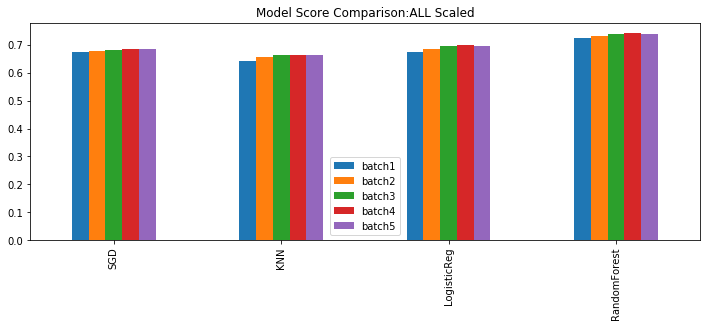

In [21]:
# cross validation ALLscaled, Visualized:
cross_val_avg_all_sa_df.plot(title='Model Score Comparison:ALL Scaled', kind='bar',
                             figsize=(12.0,4.0));

#### Cross Validation NO Feature scaling:

In [35]:
# No feature scaling prior to cross-validation.
# cross_val_score averaged for each batch:
cross_val_avg_all_df = pd.DataFrame(cross_val_avg_all, index=['batch1', 'batch2', 'batch3', 'batch4', 'batch5'],
             columns=['SGD', 'KNN', 'LogisticReg', 'RandomForest']).transpose()
cross_val_avg_all_df

,batch1,batch2,batch3,batch4,batch5
SGD,0.532240,0.632080,0.546280,0.627520,0.457200
KNN,0.630213,0.629960,0.630173,0.630267,0.629653
LogisticReg,0.673827,0.671520,0.674600,0.671240,0.673840
RandomForest,0.722133,0.730493,0.737000,0.740667,0.741280


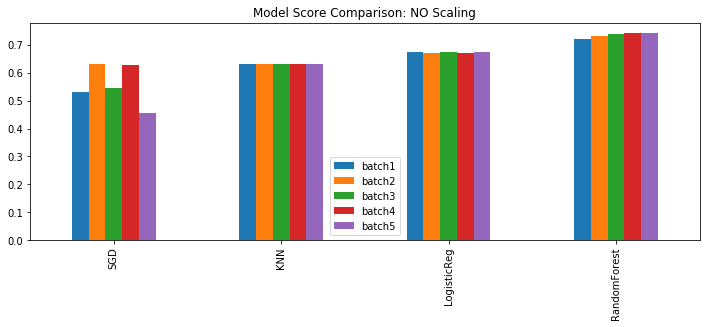

In [62]:
# cross validation with NO scaling, visualized:
cross_val_avg_all_df.plot(title='Model Score Comparison: NO Scaling', kind='bar', figsize=(12.0,4.0));

Logistic Regression has a slightly higher score using batch4 when scaled, and Random Forest results in similar scores when using batch4 or 5 group of features. <br>
Batch4 was used in finding the best hypermarameters for each model, followed by an investigation of whether using a binary(low and high severities) or multi-class classification(1,2,3, and 4) best suits our problem.

#### Multi-class or Binary?
##### Logistric Regression, Multi-Class:

In [113]:
#hyper_table=[]  # empty table for storing hyperparameter runs

In [23]:
# Split data into features and target data:
X = np.array(test_batch4_rs_50k.iloc[:,1:])
y = np.array(test_batch4_rs_50k.iloc[:,0])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

In [25]:
# Scaled X :
scaler = MinMaxScaler()
scaler.fit(X_train)
Xn_train = scaler.transform(X_train)
Xn_test = scaler.transform(X_test)

C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
# Hyperparameters tuning for model:

Cs =[0.01, 0.1, 1, 10]
solvers = ['lbfgs', 'sag', 'newton-cg']
multi_classes =['auto','multinomial']
penalties = ['l2']

for C in Cs:
    for solver in solvers:
        for multi_class in multi_classes:
            for penalty in penalties:
                
                hyper_params1 = {}  # initialize hyper params dictionary
                
                logreg = LogisticRegression(solver=solver, C=C, multi_class=multi_class,
                                            penalty=penalty, max_iter=10000)

                hyper_params1['model'] = logreg.__class__.__name__
                hyper_params1['C'] = C
                hyper_params1['multi_class'] = multi_class
                hyper_params1['solver'] = solver
                hyper_params1['penalty'] = penalty
                hyper_params1['Scaling'] = 'MinMax'
                
                # fit model
                logreg.fit(Xn_train, y_train)

                # predict y
                logreg_pred = logreg.predict(Xn_test)

                #Calculate score
                test_score = logreg.score(Xn_test,y_test)
                train_score = logreg.score(Xn_train, y_train)
                #print('LogisticRegression Test_set score is:', test_score)
                #print('LogisticRegression Train_set score is:', train_score)
                hyper_params1['test_score']= test_score
                hyper_params1['train_score']= train_score

                # Append to hyper_table
                hyper_table.append(hyper_params1)


In [121]:
hyper_table_df = pd.DataFrame(hyper_table).sort_values(by=['test_score'], ascending=False)

In [122]:
hyper_table_df # table stores all tuning runs.

,C,Scaling,model,multi_class,penalty,solver,test_score,train_score
48,10.00,MinMax,LogisticRegression,multinomial,l2,newton-cg,0.695133,0.699514
47,10.00,MinMax,LogisticRegression,auto,l2,newton-cg,0.695133,0.699514
45,10.00,MinMax,LogisticRegression,auto,l2,sag,0.695133,0.699457
46,10.00,MinMax,LogisticRegression,multinomial,l2,sag,0.695067,0.699514
11,0.10,None,LogisticRegression,auto,l2,newton-cg,0.694400,0.700257
12,0.10,None,LogisticRegression,multinomial,l2,newton-cg,0.694400,0.700257
23,10.00,None,LogisticRegression,auto,l2,newton-cg,0.694333,0.698343
24,10.00,None,LogisticRegression,multinomial,l2,newton-cg,0.694333,0.698343
17,1.00,None,LogisticRegression,auto,l2,newton-cg,0.694200,0.698771
18,1.00,None,LogisticRegression,multinomial,l2,newton-cg,0.694200,0.698771


In [123]:
#hyper_table_scaling

C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0    3    0    0]
 [   0 9174  844    6]
 [   0 3228 1250    3]
 [   0  309  180    3]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.72      0.92      0.81     10024
           3       0.55      0.28      0.37      4481
           4       0.25      0.01      0.01       492

   micro avg       0.70      0.70      0.70     15000
   macro avg       0.38      0.30      0.30     15000
weighted avg       0.65      0.70      0.65     15000



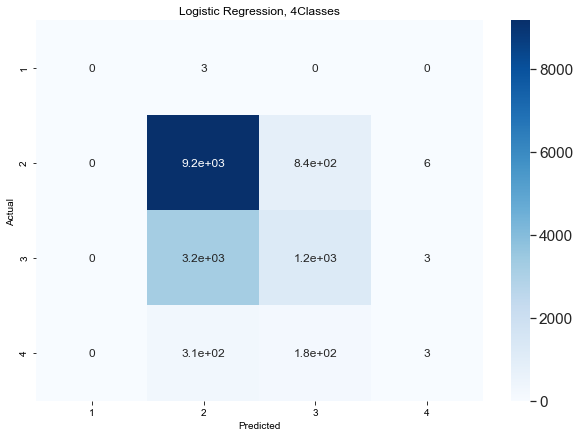

In [124]:
calc_confmatrix_and_classfrep(y_test, logreg_pred, 'Logistic Regression, 4Classes')

In the confusion matrix above, Severity 1 is *never* predicted by the model. In actuality, the test data only contains 3 counts of Severity 1, an indication that very few samples of this class is present in the original dataset. <br>
Severity 4 is represented by a total of 492 in a test set of 15,000 samples. Only 3 are correctly predicted.  Since the question we would like to tackle pertains to predicting whether the accident is severe or not rather than the intensity of the severity, the decision is made to divide the data into 2 classes only:<br>
low: Severity 1 and 2, and
high: Severity 3 and 4.<br>
This will simplify the model while not jeaopartizing the question we wish to answer.


##### Logistric Regression, Binary :

In [145]:
hyper_table_l_h = [] # list for low_high runs

In [32]:
# Make two classes low[1 and 2], and high [3 and 4]:
test_batch4_rs_50k_low_high = test_batch4_rs_50k.replace(to_replace={'Severity':{1:'low',2:'low',
                                                                   3:'high', 4:'high'}})

In [33]:
# Split data into features and target data:
X = test_batch4_rs_50k_low_high.iloc[:,1:]
y = test_batch4_rs_50k_low_high.iloc[:,0]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

In [135]:
# Scaled X :
scaler = MinMaxScaler()
scaler.fit(X_train)
Xn_train = scaler.transform(X_train)
Xn_test = scaler.transform(X_test)

C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
# Hyper-parameter tuning

#parameters to be tuned:
Cs =[0.01, 0.1, 1, 10]
solvers = ['lbfgs','newton-cg', 'sag']
multi_classes =['multinomial']
penalties = ['l2']

for C in Cs:
    for solver in solvers:
        for mlti_class in multi_classes:
            for penalty in penalties:
                
                hyper_params11 = {}  # initialize hyper params dictionary
                
                logreg = LogisticRegression(solver=solver, C=C, multi_class=multi_class,
                                            penalty=penalty, max_iter=1000)

                hyper_params11['model'] = logreg.__class__.__name__
                hyper_params11['C'] = C
                hyper_params11['multi_class'] = multi_class
                hyper_params11['solver'] = solver
                hyper_params11['penalty'] = penalty
                hyper_params11['Scaling'] = 'None'
                
                # fit model
                logreg.fit(X_train, y_train)

                # predict y
                logreg_pred = logreg.predict(X_test)

                #Calculate score
                test_score = logreg.score(X_test,y_test)
                train_score = logreg.score(X_train, y_train)
                #print('LogisticRegression Test_set score is:', test_score)
                #print('LogisticRegression Train_set score is:', train_score)
                hyper_params11['test_score']= test_score
                hyper_params11['train_score']= train_score

                # Append to hyper_table
                hyper_table_l_h.append(hyper_params11)


C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

In [149]:
pd.DataFrame(hyper_table_l_h).sort_values(by=['test_score'], ascending=False)

,C,Scaling,model,multi_class,penalty,solver,test_score,train_score
22,10.00,None,LogisticRegression,multinomial,l2,newton-cg,0.708600,0.712971
19,1.00,None,LogisticRegression,multinomial,l2,newton-cg,0.708200,0.713086
10,10.00,MinMax,LogisticRegression,multinomial,l2,newton-cg,0.707667,0.711857
11,10.00,MinMax,LogisticRegression,multinomial,l2,sag,0.707533,0.711829
9,10.00,MinMax,LogisticRegression,multinomial,l2,lbfgs,0.707400,0.710400
16,0.10,None,LogisticRegression,multinomial,l2,newton-cg,0.706933,0.712171
6,1.00,MinMax,LogisticRegression,multinomial,l2,lbfgs,0.706000,0.708571
7,1.00,MinMax,LogisticRegression,multinomial,l2,newton-cg,0.705067,0.708914
8,1.00,MinMax,LogisticRegression,multinomial,l2,sag,0.704933,0.708886
13,0.01,None,LogisticRegression,multinomial,l2,newton-cg,0.704600,0.709971


[[1680 3293]
 [1092 8935]]
              precision    recall  f1-score   support

        high       0.61      0.34      0.43      4973
         low       0.73      0.89      0.80     10027

   micro avg       0.71      0.71      0.71     15000
   macro avg       0.67      0.61      0.62     15000
weighted avg       0.69      0.71      0.68     15000



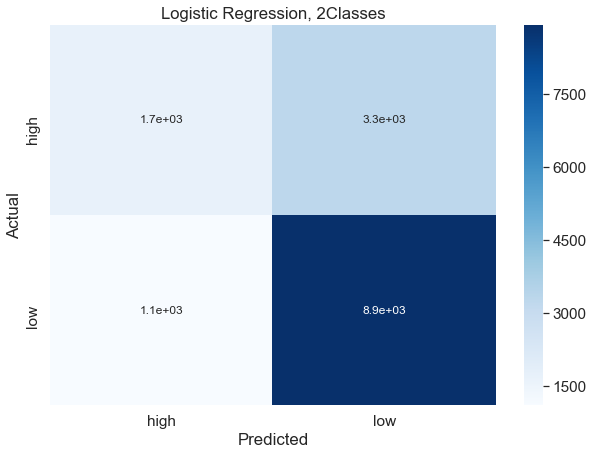

In [84]:
calc_confmatrix_and_classfrep(y_test, logreg_pred, 'Logistic Regression, 2Classes')

Limiting the problem to 2classes instead of 4, results in a slightly higher score for the test data. The best binary model had a score of 0.708, compared to a best multi-class score of 0.695.


###  Summary and conclusions

Summary:
- Imported data, and dropped columns not used in this study.<br>
- Divided the data into five different subsets, by successively adding extra features.<br>
- Used the fived subsets in 4 machine learning models(SGD,KNN, LogisticReg and RandomForest), and calculated the cross_validation score. We experimented with no-scaling/scaling of the data.<br>
- The top 2 models with the highest score are chosen for further analysis.<br>
- We've also decided to pare down the 4 accident severity classes to 2 which gave a better score, and simplified the model while maintaining its integrity in addressing the goals.<br>

Conclusions:

The four supervised machine learning methods tried here gave cross-validation scores differing by up to 34%, mostly depending on the method used, and presence or absence of scaling. The feature_subsets did not result in big variations in the score. the exception is SGD.<br>


## B) Machine Learning Models:

### + LogisticRegression
#### Run full model, binary classification:<br>


In [14]:
# Make two classes low[1 and 2], and high [3 and 4]:
test_batch4_low_high = test_batch4.replace(to_replace={'Severity':{1:'low',2:'low',
                                                                   3:'high', 4:'high'}})

In [15]:
test_batch4_low_high.head(3)

,Severity,Start_Lat,Start_Lng,Distance(mi),Precipitation_filled,Wind_Speed_filled_median,Humidity_filled_mean,Temperature_filled_mean,Visibility_filled_mean,Pressure_filled_mean,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,low,30.29520,-97.736923,0.000,0.0,6.9,67.0,84.0,10.0,29.91,...,0,0,1,0,0,0,0,0,0,0
1,high,29.97770,-90.061000,1.575,0.0,0.0,96.0,77.0,10.0,29.94,...,0,0,0,0,0,0,0,0,0,0
2,low,41.84693,-87.948100,0.000,0.0,10.4,43.0,80.1,10.0,30.06,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Split data into features and target data:
X = np.array(test_batch4_low_high.iloc[:,1:])
y = np.array(test_batch4_low_high.iloc[:,0])

In [17]:
# Split data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

In [26]:
# model:
logreg = LogisticRegression(solver='newton-cg', C=10., class_weight='multinomial', penalty='l2')
                
# fit model with scaled data
logreg.fit(X_train, y_train)

# predict y
logreg_pred = logreg.predict(X_test)

print('accuracy=', accuracy_score(y_test, logreg_pred))

C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


accuracy= 0.7071166666666666


#### Calculate confusion matrix & classification report.<br>

[[13737 25927]
 [ 9219 71117]]
              precision    recall  f1-score   support

        high       0.60      0.35      0.44     39664
         low       0.73      0.89      0.80     80336

   micro avg       0.71      0.71      0.71    120000
   macro avg       0.67      0.62      0.62    120000
weighted avg       0.69      0.71      0.68    120000



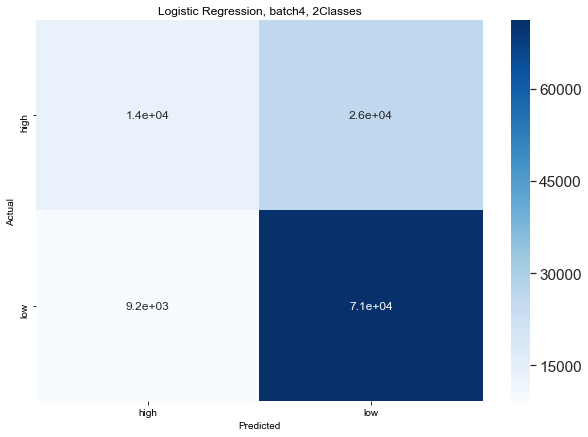

In [22]:
#No scaling
calc_confmatrix_and_classfrep(y_test, logreg_pred, 'Logistic Regression, batch4, 2Classes');


#### Analyze results:<br>
The hyperparameters tuned in section A) are used to run the binary Logistic Regression. This gives a total accuracy of about 70%. The model is better at predicting low accident severity with an f1 score of 80%. The f1 score for predicting high accident severities is 44% which indicates that the model is about twice as good in predicting the low severities.<br>
In the next section, we will try to improve this discrepency.

### + RandomForestClassifier

In [88]:
# Split data into features and target data:
X = test_batch4_rs_50k_low_high.iloc[:,1:]
y = test_batch4_rs_50k_low_high.iloc[:,0]

In [89]:
# Split data into train and test:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

In [97]:
hyper_table_rf=[] # initialize table for storing hyper parameter trials

In [98]:
hyper_params2={}    # initial hyper_parameters dictionary

In [111]:
# Hyper-parameter tuning

n_estimators =[50, 100, 200, 300, 400, 500, 600]

for estimator in n_estimators:
    
    hyper_params2 = {}  # initialize hyper params dictionary
                
    rfc = RandomForestClassifier(n_estimators=estimator, class_weight={'low':0.67,'high':0.33},
                             random_state=12)

    hyper_params2['model'] = rfc.__class__.__name__
    hyper_params2['n_estimators'] = estimator
    hyper_params2['class_weight'] = {'low':0.67,'high':0.33}
                
    # fit model
    rfc.fit(X_train, y_train)

    # predict y
    rfc_pred = rfc.predict(X_test)

    # Evaluate model:
    #Calculate accuracy_score
    acc_score = accuracy_score(y_test,rfc_pred)                
    hyper_params2['accuracy_scr']= acc_score
        
    # Convert test and predicted target to 0s and 1s
    y_val = pd.Series(y_test).replace({'low':0, 'high':1})
    rf_pred = pd.Series(rfc_pred).replace({'low':0, 'high':1})
    
    # Calculate precision, recall and f1_scaore:
    precision_scr = precision_score(y_val,rf_pred)
    recall_scr =  recall_score(y_val,rf_pred)
    f1_scr = f1_score(y_val,rf_pred)
    
    hyper_params2['precision_scr']= precision_scr
    hyper_params2['recall_scr']= recall_scr
    hyper_params2['f1_scr'] = f1_scr
    
    # Append to hyper_table
    hyper_table_rf.append(hyper_params2)


In [131]:
# convert table to dataframe and sort in ascending order by recall score:
hyper_table_rf_df = pd.DataFrame(hyper_table_rf).sort_values(by=['recall_scr'], 
                                                             ascending=False)

In [132]:
hyper_table_rf_df
# f1, precision and recall scores given are for 'high' severity

,accuracy_scr,class_weight,f1_scr,model,n_estimators,precision_scr,recall_scr
9,0.750867,"{'low': 0.67, 'high': 0.33}",0.596131,RandomForestClassifier,50,0.644393,0.554595
10,0.752533,"{'low': 0.67, 'high': 0.33}",0.591279,RandomForestClassifier,100,0.653444,0.539916
11,0.754533,"{'low': 0.67, 'high': 0.33}",0.590525,RandomForestClassifier,200,0.660612,0.533883
13,0.756133,"{'low': 0.67, 'high': 0.33}",0.591832,RandomForestClassifier,400,0.664828,0.533280
14,0.755733,"{'low': 0.67, 'high': 0.33}",0.591163,RandomForestClassifier,500,0.664076,0.532676
12,0.753600,"{'low': 0.67, 'high': 0.33}",0.588877,RandomForestClassifier,300,0.658949,0.532274
15,0.754200,"{'low': 0.67, 'high': 0.33}",0.587907,RandomForestClassifier,600,0.661802,0.528856
0,0.747467,None,0.577515,RandomForestClassifier,50,0.648385,0.520611
1,0.752000,None,0.581081,RandomForestClassifier,100,0.660353,0.518802
3,0.757800,None,0.585321,RandomForestClassifier,300,0.676874,0.515584


In the hyper_table_rf above, the precision, recall and f1score shown are for the 'high' class.<br>

The FP(false positive) means a 'low' was predicted as 'high'. This translates to a prediction of less severity and delays, yet the opposite happens. Practically, and in terms of allocation of resources, road signage and maintenance, it implies 'over allocation and under useage'.<br>

FN(false negative) means a 'high' was predicted as 'low'. The prediction here foretells of less severity and less delays, but the opposite, in fact takes place. Generally, this scenario also results in mis-managment and perhaps under allocation of resources where they are needed.<br>
If the focus of the model is prediction of this type of scenario, then we would like the **recall to be high**, and precision is of lesser importance.
However, if we would like to reduce the false positives too, or we would like the best **overall** model, then the the preference is for a higher f1_score and accuracy.<br>

For our purpose, the focus is on the latter. These conditions are best met by model '10' above. With an n-estimator of 100, and weighted classes.

[[2630 2343]
 [1344 8683]]
              precision    recall  f1-score   support

        high       0.66      0.53      0.59      4973
         low       0.79      0.87      0.82     10027

   micro avg       0.75      0.75      0.75     15000
   macro avg       0.72      0.70      0.71     15000
weighted avg       0.75      0.75      0.75     15000



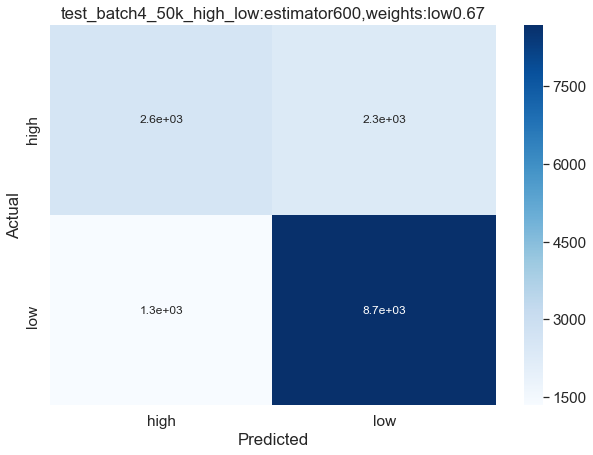

In [114]:
# Model 15 Confusion Matrix and Classification Report:
calc_confmatrix_and_classfrep(y_test, rfc_pred, 'test_batch4_50k_high_low:estimator600,
                              weights:low 0.67');

#### Implement Hyper-parameters:

In [167]:
# Split data into features and target data:
X = test_batch4_rs_50k_low_high.iloc[:,1:]
y = test_batch4_rs_50k_low_high.iloc[:,0]

In [168]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

rfc = RandomForestClassifier(n_estimators=100, class_weight={'low':0.67,'high':0.33},
                             random_state=12)

rfc.fit(X_train,y_train)
rfc_pred=rfc.predict(X_test)

# Convert test and predicted target to 0s and 1s
y_val = pd.Series(y_test).replace({'low':0, 'high':1})
rf_pred = pd.Series(rfc_pred).replace({'low':0, 'high':1})

In [169]:
print('accuracy =',accuracy_score(y_val,rf_pred))
print('precision =',precision_score(y_val,rf_pred))
print('recall =',recall_score(y_val,rf_pred))
print('f1_score =',f1_score(y_val,rf_pred))

accuracy = 0.7454666666666667
precision = 0.6401358893472459
recall = 0.5304645083450633
f1_score = 0.5801627446668133


[[24441 15223]
 [10793 69543]]
              precision    recall  f1-score   support

        high       0.69      0.62      0.65     39664
         low       0.82      0.87      0.84     80336

   micro avg       0.78      0.78      0.78    120000
   macro avg       0.76      0.74      0.75    120000
weighted avg       0.78      0.78      0.78    120000



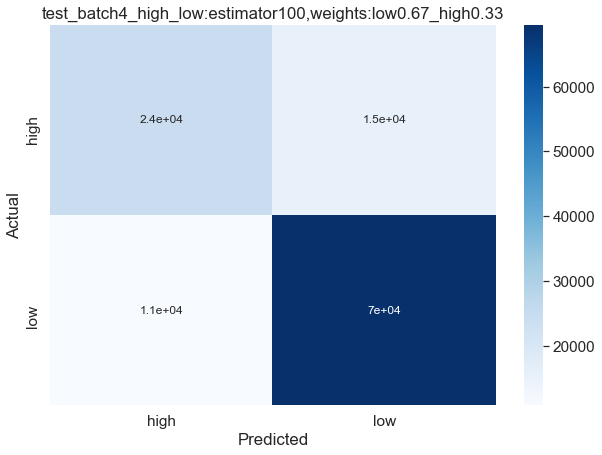

In [137]:
# Model 10 in hyper_table_rf:
calc_confmatrix_and_classfrep(y_test, rfc_pred, 'test_batch4_high_low:estimator100,
                              weights:low0.67_high0.33');

+ True Positives are those which are predicted as *high* which are actually *high*<br>
+ False Positives are those which are predicted as *high* which are actually *low*<br>
+ True Negatives are those which are predicted as *low* which are actually *low*<br>
+ False Negatives are those which are predicted *low* which are actually *high*<br>

#### Most Important Features:

In [35]:
# Extract most important features:
feature_imp = pd.Series(rfc.feature_importances_, 
                        index=test_batch4_low_high.iloc[:,1:].columns).sort_values(ascending=False)
#pd.DataFrame(feature_imp)

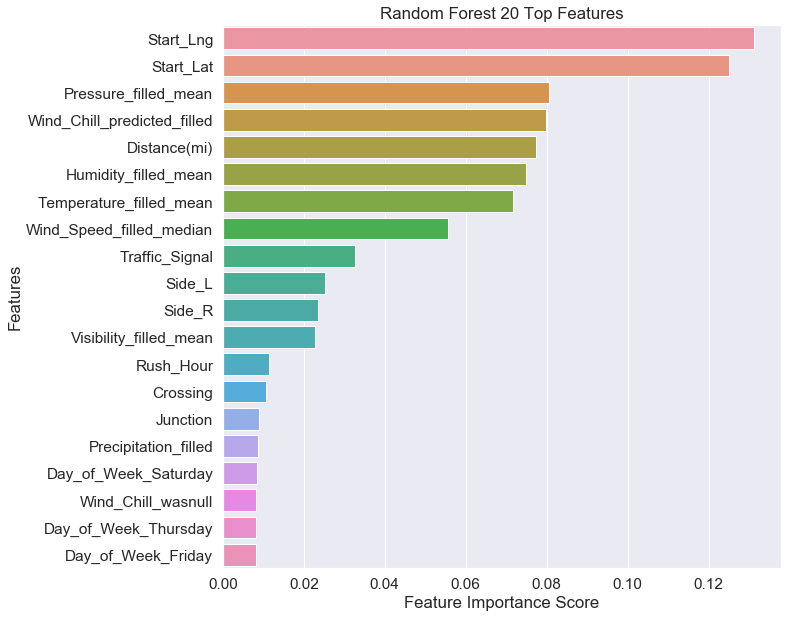

In [36]:
# Visualize the Top 20 most important features:
plt.figure(figsize=[10,10])
sns.barplot(x=feature_imp.head(20), y=feature_imp.head(20).index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Random Forest 20 Top Features")
plt.show();

In [165]:
#Take top 20 most important features Distance and re-run
test_batch4_dropdistance = test_batch4_rs_50k_low_high.loc[:,['Severity','Start_Lng', 'Start_Lat', 'Pressure_filled_mean',
                                                          'Wind_Chill_predicted_filled', 'Distance(mi)', 'Humidity_filled_mean',
                                                          'Temperature_filled_mean', 'Wind_Speed_filled_median', 'Traffic_Signal',
                                                          'Side_L', 'Side_R', 'Visibility_filled_mean', 'Rush_Hour', 'Crossing',
                                                          'Junction', 'Precipitation_filled', 'Day_of_Week_Saturday', 
                                                          'Wind_Chill_wasnull', 'Day_of_Week_Thursday', 'Day_of_Week_Friday']]

Taking only the top 20 features, yields:<br>
Accuracy             $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ = 0.7454<br>
Precision(high, low) $\;\;\;$= 0.64,0.79<br>
Recall(high, low)    $\;\;\;\;\;\;$ = 0.53,0.85 <br>
f1_score(high, low)  $\;\;\;$ = 0.58,0.82<br>

[[2638 2335]
 [1483 8544]]
              precision    recall  f1-score   support

        high       0.64      0.53      0.58      4973
         low       0.79      0.85      0.82     10027

   micro avg       0.75      0.75      0.75     15000
   macro avg       0.71      0.69      0.70     15000
weighted avg       0.74      0.75      0.74     15000



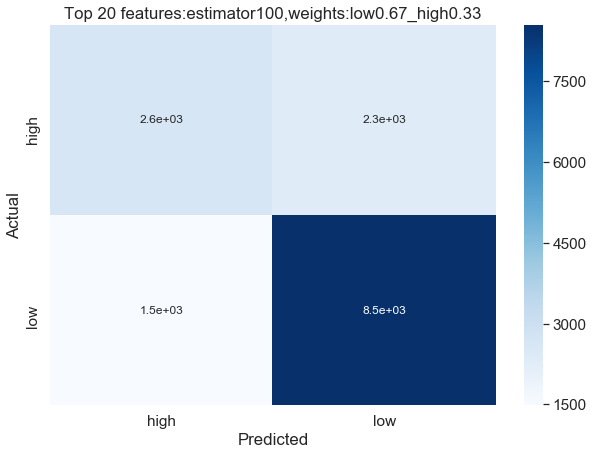

In [170]:
calc_confmatrix_and_classfrep(y_test, rfc_pred, 
                              'Top 20 features:estimator100,weights:low0.67_high0.33');

###  Summary and conclusions:

- Implemented tuned logistic regression parameters to obtain the highest diagonal values in the confusion matrix, and lowest False Positives(FPs) and False Negatives(FNs).
- Hyper-parameter tuning for RandomForest model to achieve highest accuracy and f1 score. This included:
    - Experimenting with weighted inputs: weights of 0.67 for lows and 0.33 for highs gave best results.
    - Calculating the 'most important' top 20 features, and running the model: this resulted in lower accuracy and f1 scores.
- the conclusion is: Random Forest gives better overal results with an accuracy value of 78%, compared to Logistic Regression's 71%.


## C) Final Pipeline: 

At this point, the best hyper-parameters are known, and we make a pipeline to run Random Forest with the complete dataset batch4.<br>
Overall, 93984 severity values out of 120000 are correctly predicted (78%). The remaining 22% were incorrectly predicted as follows:<br>
15223 samples are predicted to be low, but they are actually high. This is 13% of the entire dataset.<br>
10793 samples (9% of the total dataset) are predicted to be high, but they are actually low.<br><br>
62% of the highs $(24441/24441+15223)$, and 87% of the lows $(69543/69543+10793)$ are correctly predicted (recall), which indicates the model is still much better at predicting lows. This is inspite of weighting the input parameters in order to compensate for the sample numbers.<br>


In [173]:
from sklearn.pipeline import Pipeline

In [187]:
# Split data into features and target data:
X = test_batch4_low_high.iloc[:,1:]
y = test_batch4_low_high.iloc[:,0]

In [188]:
model = RandomForestClassifier(n_estimators=100, 
                               class_weight={'low':0.67,'high':0.33},random_state=12)

# Modeling code in a pipeline
my_pipeline = Pipeline(steps=[('model', model)])

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)


# fit model 
my_pipeline.fit(X_train, y_train)

# Get predictions
model_preds = my_pipeline.predict(X_test)

# Evaluate the model
print('Accuracy=', accuracy_score(y_test, model_preds))
print(confusion_matrix(y_test, model_preds))
print(classification_report(y_test, model_preds))

Accuracy= 0.7832
[[24441 15223]
 [10793 69543]]
              precision    recall  f1-score   support

        high       0.69      0.62      0.65     39664
         low       0.82      0.87      0.84     80336

   micro avg       0.78      0.78      0.78    120000
   macro avg       0.76      0.74      0.75    120000
weighted avg       0.78      0.78      0.78    120000



###  Recommended Future Work:

There is still room for improvement of the model in order to have better predictions of low and high severity accidents. some of the work that can be done is listed below.

- Further work to include:
    + Try using classification voting ensemble methods, whereby predictions for each label are summed and the label with the majority vote is predicted. This can be tried in two ways: equally weighting the models, or using weighted average(blending) .<br>
    
    + Use partial_fit to incrementally train the classifier using successive batches from the 3Million row record. This method will also allow occasional updates with additional data over time.
    + Try additional feature engineering on the columns (e.g. $x^2$), and monitor the effect on model improvement (e.g. increasing accuracy).